# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model
## Context
Retinal Optical Coherence Tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 1.](https://i.imgur.com/fSTeZMd.png)

Figure 1. Representative Optical Coherence Tomography Images and the Workflow Diagram \[Kermany et. al. 2018\]

(A) (Far left) Choroidal Neo-Vascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic Macular Edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Content
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).
* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

* Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.

## Acknowledgements
* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Installing and Importing Libraries

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

## Importing Dataset and Data Pre-Processing

create train and test directory 

In [3]:
data_dir = './data/OCT2017_/'
train_data_dir= './data/OCT2017_/train/'
val_data_dir= './data/OCT2017_/val/'
test_data_dir= './data/OCT2017_/test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

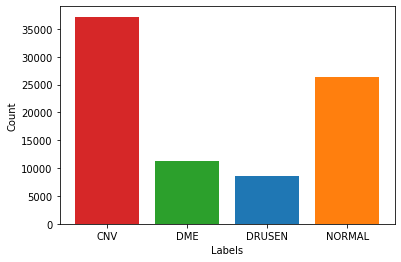

In [4]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Image Histogram (Tonal Distribution)
* Histogram of a normal retina image in the train dataset:

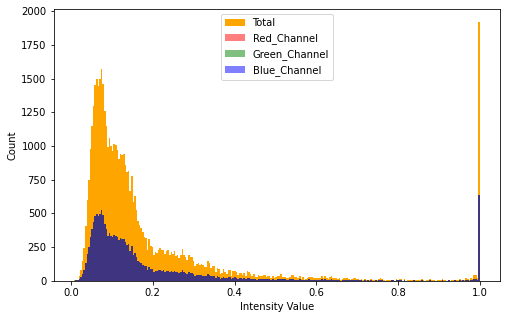

In [5]:
image = mpimg.imread(data_dir + '/train/NORMAL/NORMAL-1001666-1.jpeg')
color_img= gray2rgb(resize(image, (128, 128)))
plt.rcParams['figure.figsize'] = (8.0, 5.0)
_ = plt.hist(color_img.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(color_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(color_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(color_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.savefig('histogram.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

### Sample Images from the Dataset

Normal


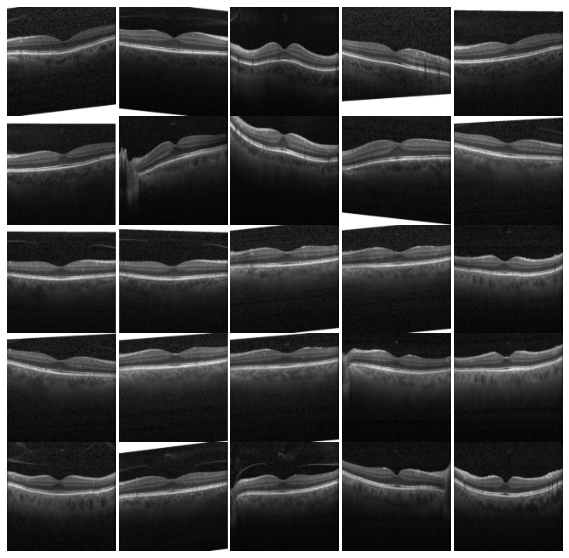

In [6]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


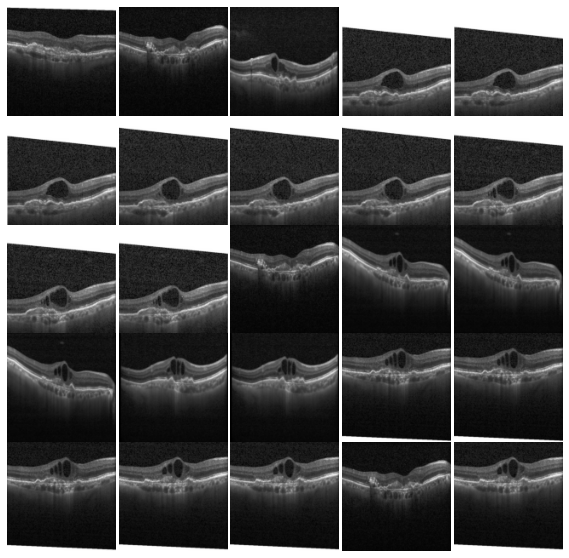

In [7]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


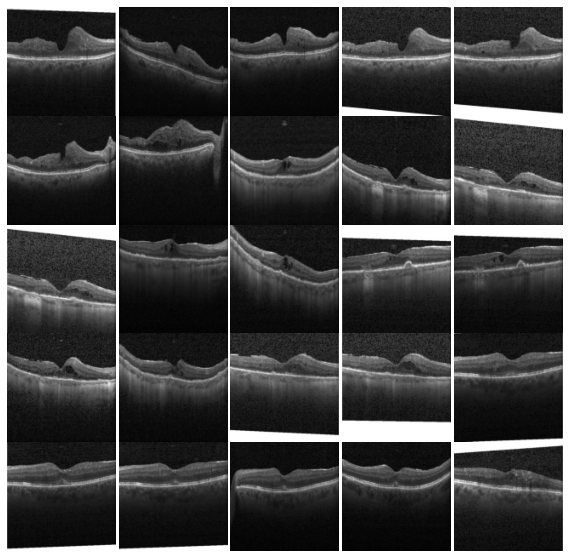

In [8]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


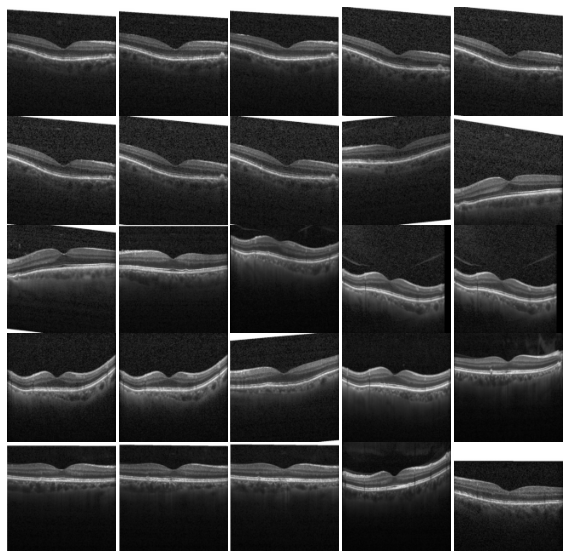

In [9]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [10]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [11]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [12]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

### Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [13]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

### Baseline Model Training

In [15]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [16]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [17]:
numepochs = 5
batch_size = 128
checkpoint_filepath = './checkpoints_baseline/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callbacks_list = [earlystop,checkpoint]
history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list)

Epoch 1/5
2609/2609 [==============================] - 334s 127ms/step - loss: 0.6752 - accuracy: 0.7549 - val_loss: 0.4841 - val_accuracy: 0.8125
Epoch 2/5
2609/2609 [==============================] - 332s 127ms/step - loss: 0.5104 - accuracy: 0.8163 - val_loss: 0.3754 - val_accuracy: 0.8750
Epoch 3/5
2609/2609 [==============================] - 333s 128ms/step - loss: 0.4749 - accuracy: 0.8285 - val_loss: 0.3580 - val_accuracy: 0.9375
Epoch 4/5
2609/2609 [==============================] - 335s 128ms/step - loss: 0.4545 - accuracy: 0.8367 - val_loss: 0.3666 - val_accuracy: 0.9375
Epoch 5/5
2609/2609 [==============================] - 329s 126ms/step - loss: 0.4415 - accuracy: 0.8407 - val_loss: 0.3143 - val_accuracy: 0.9062


Evaluations on Test Dataset

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 2s 52ms/step - loss: 0.3531 - accuracy: 0.8709
Test Loss:  0.3531021177768707
Test Accuracy:  0.8708677887916565


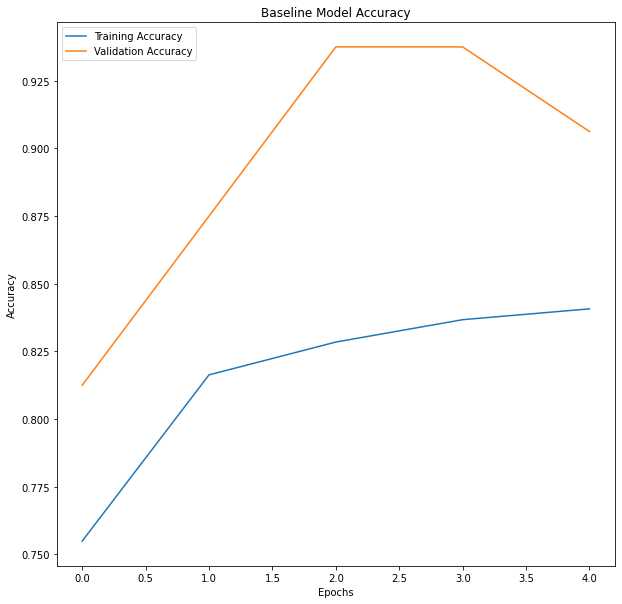

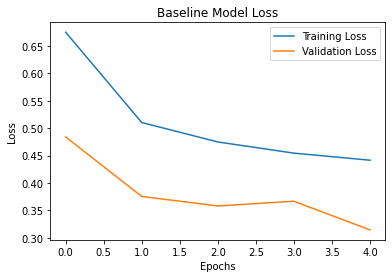

In [19]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

31/31 [==============================] - 1s 35ms/step


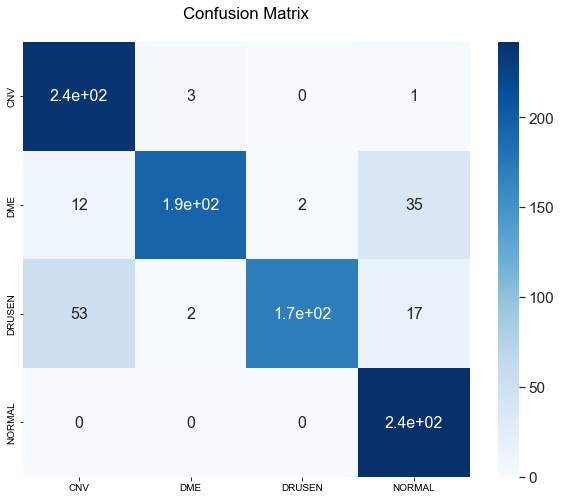

Classification Report

              precision    recall  f1-score   support

         CNV       0.79      0.98      0.87       242
         DME       0.97      0.80      0.88       242
      DRUSEN       0.99      0.70      0.82       242
      NORMAL       0.82      1.00      0.90       242

    accuracy                           0.87       968
   macro avg       0.89      0.87      0.87       968
weighted avg       0.89      0.87      0.87       968



In [20]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Save the model

In [21]:
# save model and architecture to single file
model.save("./retinal_oct_api-main/model/retinal-oct-adam.h5")
print("Saved model to disk")

Saved model to disk


Prediction test

In [23]:
model = tf.keras.models.load_model('./retinal_oct_api-main/model/retinal-oct-adam.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

test_image = tf.keras.utils.load_img(data_dir + '/test/CNV/CNV-53018-1.jpeg', target_size = (150, 150)) 
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = np.argmax(model.predict(test_image))
print(result)
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(result)])

1/1 [==============================] - 1s 620ms/step
0
CNV


### Enhanced Model Training

In [24]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the objective metric
metric = 'accuracy'

# Define the model building function
def build_model(hp):
    # Load the VGG16 model
    vgg16 = keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_width, img_height, channels)
    )

    # Freeze the base model layers
    for layer in vgg16.layers:
        layer.trainable = False

    # Add new classification layers
    x = layers.Flatten()(vgg16.output)
    x = layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = layers.Dense(4, activation='softmax')(x)

    # Create the model
    model = keras.models.Model(inputs=vgg16.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=[metric]
    )

    return model

# Define the hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective=metric,
    max_trials=5,
    directory='tuner_dir',
    project_name='vgg16-adam'
)

# Train the model
tuner.search(train_generator, epochs=10, validation_data=valid_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

Trial 5 Complete [00h 54m 56s]
accuracy: 0.8231637477874756

Best accuracy So Far: 0.8523309826850891
Total elapsed time: 04h 38m 29s
INFO:tensorflow:Oracle triggered exit
31/31 [==============================] - 1s 37ms/step - loss: 0.1659 - accuracy: 0.8998
Test accuracy: 0.8997933864593506


In [27]:
# save model and architecture to single file
best_model.save("./retinal_oct_api-main/model/retinal-oct-adam-tuned.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the objective metric
metric = 'accuracy'

# Define the model building function
def build_model(hp):
    # Load the VGG16 model
    vgg16 = keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_width, img_height, channels)
    )

    # Freeze the base model layers
    for layer in vgg16.layers:
        layer.trainable = False

    # Add new classification layers
    x = layers.Flatten()(vgg16.output)
    x = layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = layers.Dense(4, activation='softmax')(x)

    # Create the model
    model = keras.models.Model(inputs=vgg16.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.SGD(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=[metric]
    )

    return model

# Define the hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective=metric,
    max_trials=5,
    directory='tuner_dir',
    project_name='vgg16-sgd'
)

# Train the model
tuner.search(train_generator, epochs=10, validation_data=valid_generator)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

Trial 5 Complete [00h 55m 12s]
accuracy: 0.8104666471481323

Best accuracy So Far: 0.8104666471481323
Total elapsed time: 04h 45m 16s
INFO:tensorflow:Oracle triggered exit
31/31 [==============================] - 2s 49ms/step - loss: 0.2595 - accuracy: 0.7417
Test accuracy: 0.7417355179786682


In [30]:
# save model and architecture to single file
best_model.save("./retinal_oct_api-main/model/retinal-oct-sgd-tuned.h5")
print("Saved model to disk")

Saved model to disk
